## **Deep Learning CNN model to recognize face**
<br>This script uses a database of images and creates CNN model on top of it to test if the given image is recognized correctly or not

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# importing required libraries

from keras.preprocessing.image import ImageDataGenerator


import pickle


import time


from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout


from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode
import cv2


import numpy as np
from keras.preprocessing import image


import os

### **IMAGE PRE-PROCESSING for TRAINING and TESTING data**

In [3]:
# specifying the folder where images are present
TrainingImagePath='/content/drive/MyDrive/biom-project/Final Training Images'

# defining pre-processing transformations on raw images of training data to
# generate  slightly twisted versions of the original image, which leads to a
# better model,  since it learns on the good and bad mix of images
train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# no transformations are done on the testing images
test_datagen = ImageDataGenerator()


# generating the training data
training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')

# generating the testing data
test_set = test_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical')


# Printing class labels for each face
test_set.class_indices

Found 103 images belonging to 8 classes.
Found 103 images belonging to 8 classes.


{'.ipynb_checkpoints': 0,
 'face1': 1,
 'face2': 2,
 'face3': 3,
 'face4': 4,
 'face5': 5,
 'shourya': 6,
 'shweta': 7}

### **Creating lookup table for all faces**

In [4]:
# class_indices have the numeric tag for each face
TrainClasses = training_set.class_indices


# Storing the face and the numeric tag for future reference
ResultMap={}
for faceValue,faceName in zip(TrainClasses.values(), TrainClasses.keys()):
    ResultMap[faceValue]=faceName

# The model will give answer as a numeric tag and this mapping will help to get
# the corresponding face name for it
print("Mapping of Face and its ID", ResultMap)


# Saving the face map for future reference
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)


# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)
print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: '.ipynb_checkpoints', 1: 'face1', 2: 'face2', 3: 'face3', 4: 'face4', 5: 'face5', 6: 'shourya', 7: 'shweta'}

 The Number of output neurons:  8


### **Create CNN deep learning model**

In [9]:
# Initializing the Convolutional Neural Network
classifier= Sequential()

# Adding the first layer of CNN
# we are using the format (64,64,3) because we are using TensorFlow backend
# It means 3 matrix of size (64X64) pixels representing Red, Green and Blue components of pixels
classifier.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(64,64,3), activation='relu'))

# MAX Pooling
classifier.add(MaxPool2D(pool_size=(2,2)))


# ADDITIONAL LAYER of CONVOLUTION for better accuracy
classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))

classifier.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2,2)))


# FLattening
classifier.add(Flatten())


# Fully Connected Neural Network
classifier.add(Dropout(0.1))
classifier.add(Dense(64, activation='relu'))

classifier.add(Dense(OutputNeurons, activation='softmax'))


# Compiling the CNN
classifier.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])


# Starting the model training
StartTime=time.time()


classifier.fit(
                    training_set,
                    epochs=25,
                    validation_data=test_set,
                    validation_steps=10)

EndTime=time.time()
print("###### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ######')

Epoch 1/25
4/4 [==============================] - ETA: 0s - loss: 39.1399 - accuracy: 0.1650

4/4 [==============================] - 7s 653ms/step - loss: 39.1399 - accuracy: 0.1650 - val_loss: 16.0079 - val_accuracy: 0.1456
Epoch 2/25
4/4 [==============================] - 3s 471ms/step - loss: 13.3706 - accuracy: 0.1845
Epoch 3/25
4/4 [==============================] - 2s 443ms/step - loss: 3.6941 - accuracy: 0.1456
Epoch 4/25
4/4 [==============================] - 1s 266ms/step - loss: 2.2297 - accuracy: 0.1553
Epoch 5/25
4/4 [==============================] - 2s 317ms/step - loss: 1.8276 - accuracy: 0.3204
Epoch 6/25
4/4 [==============================] - 1s 255ms/step - loss: 1.7411 - accuracy: 0.3204
Epoch 7/25
4/4 [==============================] - 3s 494ms/step - loss: 1.4481 - accuracy: 0.4951
Epoch 8/25
4/4 [==============================] - 2s 496ms/step - loss: 1.1703 - accuracy: 0.5825
Epoch 9/25
4/4 [==============================] - 2s 294ms/step - loss: 1.0477 - accuracy: 0.6505
Epoch 10/25
4/4 [==============================] - 1s 284ms/step - loss: 0.8474 - ac

### **Taking camera input**

<IPython.core.display.Javascript object>

(480, 640)
Saved to /content/test.jpg


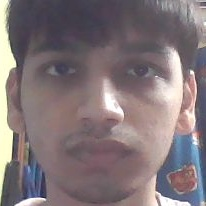

In [10]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

def take_photo(filename='/content/test.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      cropped_face = img[y:y + h, x:x + w]
  # save image
  cv2.imwrite(filename, cropped_face)
  return filename

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

### **Final Predictions**

In [11]:
ImagePath='/content/test.jpg'
test_image=image.load_img(ImagePath,target_size=(64, 64))
test_image=image.img_to_array(test_image)

test_image=np.expand_dims(test_image,axis=0)

result=classifier.predict(test_image,verbose=0)

print(result)

# if np.max(result) > 0.8:
#   print('Prediction is: ',ResultMap[np.argmax(result)])
# else:
#   print('No match')

print('Prediction is: ',ResultMap[np.argmax(result)])

[[3.9340227e-13 7.4107213e-08 3.4969294e-10 3.0759896e-08 8.4722922e-07
  7.6367506e-08 9.9943382e-01 5.6512939e-04]]
Prediction is:  shourya


<hr>

### **Cropping images**

In [ ]:
# Directory path
directory = '/content/drive/MyDrive/biom-project/Final Training Images/'

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Iterate over files in the directory
for filename in os.listdir(directory):
    # Check if the file is a regular file (not a directory)
    if os.path.isfile(os.path.join(directory, filename)):
        # Process the file (e.g., print its name)
        frame = cv2.imread(os.path.join(directory, filename))
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the frame
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

        # Process each detected face
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Crop the face region from the frame
            cropped_face = frame[y:y + h, x:x + w]

            output_path = f'/content/drive/MyDrive/biom-project/Final Training Images/{filename}'

            cv2.imwrite(output_path, cropped_face)
